In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
# Define your data transformation
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(5, 15)),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.5, 0.5, 0.5],
    #     std=[0.5, 0.5, 0.5]
    # )
])

test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])


In [ ]:
batch_size = 16

# Load data
train_dataset = CustomImageDataset(root_dir='/content/drive/MyDrive/AE_xray/train', transform=train_transform)
test_dataset = CustomImageDataset(root_dir='/content/drive/MyDrive/AE_xray/test', transform=test_transform)

# Dataloader
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Encoder(nn.Module):
  def __init__(self , input_size = 10000 , hidden_size1 = 2500, hidden_size2 = 1000 , hidden_size3 = 500, hidden_size4 = 200, z_dim = 100):
    super().__init__()
    self.fc1 = nn.Linear(input_size , hidden_size1)
    self.fc2 = nn.Linear(hidden_size1 , hidden_size2)
    self.fc3 = nn.Linear(hidden_size2 , hidden_size3)
    self.fc4 = nn.Linear(hidden_size3 , hidden_size4)
    self.fc5 = nn.Linear(hidden_size4 , z_dim)
    self.relu = nn.ReLU()
  def forward(self , x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self , output_size = 10000 , hidden_size1 = 2500, hidden_size2 = 1000 , hidden_size3 = 500, hidden_size4 = 200, z_dim = 100):
    super().__init__()
    self.fc1 = nn.Linear(z_dim , hidden_size4)
    self.fc2 = nn.Linear(hidden_size4 , hidden_size3)
    self.fc3 = nn.Linear(hidden_size3 , hidden_size2)
    self.fc4 = nn.Linear(hidden_size2 , hidden_size1)
    self.fc5 = nn.Linear(hidden_size1 , output_size)
    self.relu = nn.ReLU()
  def forward(self , x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    x = torch.sigmoid(self.fc5(x))
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
enc = Encoder().to(device)
dec = Decoder().to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

In [ ]:
train_loss = []
num_epochs = 500
checkpoint_path = "/content/drive/MyDrive/model/Autoencoder/new_xray_checkpoint_30z_5h_200e.pth"

In [ ]:
# Check if a checkpoint exists to resume training
if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path)
  enc.load_state_dict(checkpoint["enc_state_dict"])
  dec.load_state_dict(checkpoint["dec_state_dict"])
  optimizer_enc.load_state_dict(checkpoint["optimizer_enc_state_dict"])
  optimizer_dec.load_state_dict(checkpoint["optimizer_dec_state_dict"])
  train_loss = checkpoint["loss"]
  start_epoch = checkpoint["epoch"] + 1  # Start from the next epoch after the loaded checkpoint
  print("Resume training from epoch", start_epoch)
else:
  start_epoch = 1

Resume training from epoch 411


In [ ]:
total_batches = len(train_dl)
for epoch in range(start_epoch,num_epochs+1):
    train_epoch_loss = 0
    start_time = time.time()
    # Create a tqdm progress bar for the epoch
    epoch_progress = tqdm(enumerate(train_dl, 1), total=total_batches, desc=f'Epoch {epoch}/{num_epochs}', leave=False)
    for step, imgs in epoch_progress:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        # print(imgs.shape)
        latents = enc(imgs)
        output = dec(latents)
        loss = loss_fn(output, imgs)
        train_epoch_loss += loss.item()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
        # Update the progress bar description with current step and loss
        # epoch_progress.set_description(f'Epoch {epoch}/{num_epochs}, Step {step}/{total_batches}, Loss: {loss.item():.4f}')
    train_loss.append(train_epoch_loss)
    # Close the tqdm progress bar for the epoch
    epoch_progress.close()

    # Print the epoch loss after each epoch
    print('\n')
    print(f'Epoch {epoch}/{num_epochs}, Loss: {train_epoch_loss:.4f}, Time taken: [{time.time() - start_time:.2f}s]')

    # Save the model checkpoint along with training-related information
    checkpoint = {
        'epoch': epoch,
        'enc_state_dict': enc.state_dict(),  # Save the encoder model's state dictionary
        'dec_state_dict':dec.state_dict(),
        'optimizer_enc_state_dict': optimizer_enc.state_dict(),  # Save the optimizer state
        'optimizer_dec_state_dict': optimizer_dec.state_dict(),
        'loss': train_loss,  # Save the loss
    }
    torch.save(checkpoint, checkpoint_path)




Epoch 411/500, Loss: 0.6645, Time taken: [34.13s]




Epoch 412/500, Loss: 0.6781, Time taken: [34.67s]




Epoch 413/500, Loss: 0.6664, Time taken: [36.45s]




Epoch 414/500, Loss: 0.6609, Time taken: [33.72s]




Epoch 415/500, Loss: 0.6564, Time taken: [34.03s]




Epoch 416/500, Loss: 0.6396, Time taken: [34.83s]




Epoch 417/500, Loss: 0.6591, Time taken: [35.18s]




Epoch 418/500, Loss: 0.6611, Time taken: [34.53s]




Epoch 419/500, Loss: 0.6646, Time taken: [33.66s]




Epoch 420/500, Loss: 0.6586, Time taken: [33.40s]




Epoch 421/500, Loss: 0.6505, Time taken: [33.82s]




Epoch 422/500, Loss: 0.6665, Time taken: [34.42s]




Epoch 423/500, Loss: 0.6532, Time taken: [35.19s]




Epoch 424/500, Loss: 0.6459, Time taken: [33.59s]




Epoch 425/500, Loss: 0.6555, Time taken: [34.46s]




Epoch 426/500, Loss: 0.6403, Time taken: [34.04s]




Epoch 427/500, Loss: 0.6523, Time taken: [33.18s]




Epoch 428/500, Loss: 0.6360, Time taken: [33.56s]




Epoch 429/500, Loss: 0.6595, Time taken: [33.28s]




Epoch 430/500, Loss: 0.6509, Time taken: [33.91s]




Epoch 431/500, Loss: 0.6556, Time taken: [34.09s]




Epoch 432/500, Loss: 0.6562, Time taken: [34.18s]




Epoch 433/500, Loss: 0.6496, Time taken: [33.11s]




Epoch 434/500, Loss: 0.6499, Time taken: [34.10s]




Epoch 435/500, Loss: 0.6354, Time taken: [34.79s]




Epoch 436/500, Loss: 0.6419, Time taken: [33.01s]




Epoch 437/500, Loss: 0.6463, Time taken: [32.81s]




Epoch 438/500, Loss: 0.6564, Time taken: [33.03s]




Epoch 439/500, Loss: 0.6514, Time taken: [32.88s]




Epoch 440/500, Loss: 0.6478, Time taken: [34.53s]




Epoch 441/500, Loss: 0.6308, Time taken: [32.28s]




Epoch 442/500, Loss: 0.6699, Time taken: [33.96s]




Epoch 443/500, Loss: 0.6704, Time taken: [32.52s]




Epoch 444/500, Loss: 0.6414, Time taken: [35.16s]




Epoch 445/500, Loss: 0.6615, Time taken: [33.21s]




Epoch 446/500, Loss: 0.6542, Time taken: [34.33s]




Epoch 447/500, Loss: 0.6271, Time taken: [34.20s]




Epoch 448/500, Loss: 0.6405, Time taken: [32.96s]




Epoch 449/500, Loss: 0.6382, Time taken: [35.05s]




Epoch 450/500, Loss: 0.6427, Time taken: [32.85s]




Epoch 451/500, Loss: 0.6355, Time taken: [34.17s]




Epoch 452/500, Loss: 0.6349, Time taken: [32.91s]




Epoch 453/500, Loss: 0.6350, Time taken: [34.35s]




Epoch 454/500, Loss: 0.6429, Time taken: [34.40s]




Epoch 455/500, Loss: 0.6562, Time taken: [33.50s]




Epoch 456/500, Loss: 0.6365, Time taken: [32.84s]




Epoch 457/500, Loss: 0.6428, Time taken: [33.48s]




Epoch 458/500, Loss: 0.6402, Time taken: [35.77s]




Epoch 459/500, Loss: 0.6551, Time taken: [32.69s]




Epoch 460/500, Loss: 0.6406, Time taken: [34.30s]




Epoch 461/500, Loss: 0.6451, Time taken: [33.00s]




Epoch 462/500, Loss: 0.6489, Time taken: [34.04s]




Epoch 463/500, Loss: 0.6332, Time taken: [34.28s]




Epoch 464/500, Loss: 0.6573, Time taken: [34.03s]




Epoch 465/500, Loss: 0.6308, Time taken: [32.39s]




Epoch 466/500, Loss: 0.6359, Time taken: [33.52s]




Epoch 467/500, Loss: 0.6328, Time taken: [33.86s]




Epoch 468/500, Loss: 0.6401, Time taken: [33.00s]




Epoch 469/500, Loss: 0.6438, Time taken: [34.74s]




Epoch 470/500, Loss: 0.6344, Time taken: [33.21s]




Epoch 471/500, Loss: 0.6368, Time taken: [33.93s]




Epoch 472/500, Loss: 0.6416, Time taken: [34.81s]




Epoch 473/500, Loss: 0.6366, Time taken: [34.02s]




Epoch 474/500, Loss: 0.6311, Time taken: [34.12s]




Epoch 475/500, Loss: 0.6298, Time taken: [33.08s]




Epoch 476/500, Loss: 0.6383, Time taken: [35.43s]




Epoch 477/500, Loss: 0.6317, Time taken: [34.53s]




Epoch 478/500, Loss: 0.6332, Time taken: [33.15s]




Epoch 479/500, Loss: 0.6389, Time taken: [34.51s]




Epoch 480/500, Loss: 0.6354, Time taken: [33.24s]




Epoch 481/500, Loss: 0.6302, Time taken: [35.10s]




Epoch 482/500, Loss: 0.6488, Time taken: [34.94s]




Epoch 483/500, Loss: 0.6473, Time taken: [33.07s]




Epoch 484/500, Loss: 0.6528, Time taken: [34.59s]




Epoch 485/500, Loss: 0.6488, Time taken: [35.53s]




Epoch 486/500, Loss: 0.6491, Time taken: [33.04s]




Epoch 487/500, Loss: 0.6552, Time taken: [34.96s]




Epoch 488/500, Loss: 0.6563, Time taken: [34.52s]




Epoch 489/500, Loss: 0.6326, Time taken: [34.48s]




Epoch 490/500, Loss: 0.6250, Time taken: [36.30s]




Epoch 491/500, Loss: 0.6492, Time taken: [34.33s]




Epoch 492/500, Loss: 0.6471, Time taken: [35.20s]




Epoch 493/500, Loss: 0.6405, Time taken: [34.52s]




Epoch 494/500, Loss: 0.6278, Time taken: [35.11s]




Epoch 495/500, Loss: 0.6182, Time taken: [35.15s]




Epoch 496/500, Loss: 0.6442, Time taken: [34.81s]




Epoch 497/500, Loss: 0.6247, Time taken: [33.53s]




Epoch 498/500, Loss: 0.6260, Time taken: [34.68s]




Epoch 499/500, Loss: 0.6506, Time taken: [34.92s]




Epoch 500/500, Loss: 0.6460, Time taken: [33.65s]


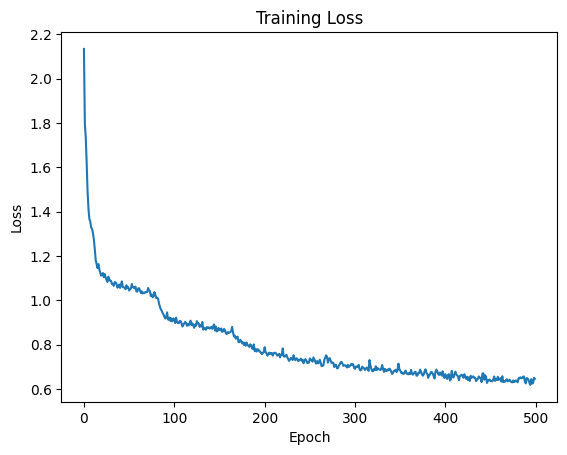

In [ ]:
checkpoint = torch.load(checkpoint_path)
saved_losses = checkpoint['loss']

# Plot the loss values
plt.plot(saved_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

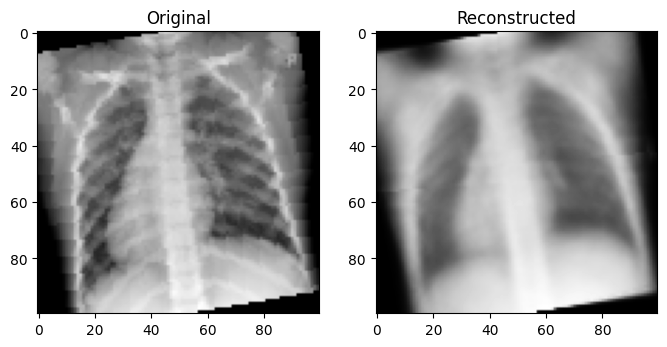

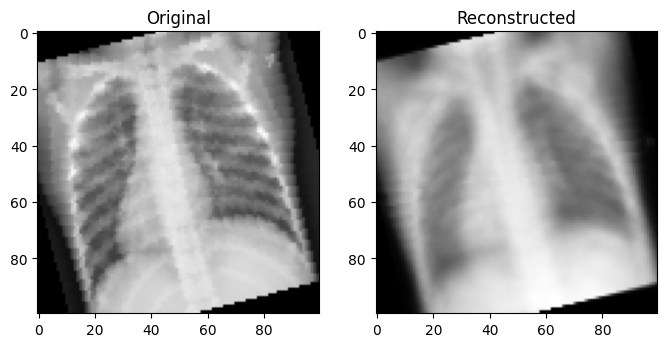

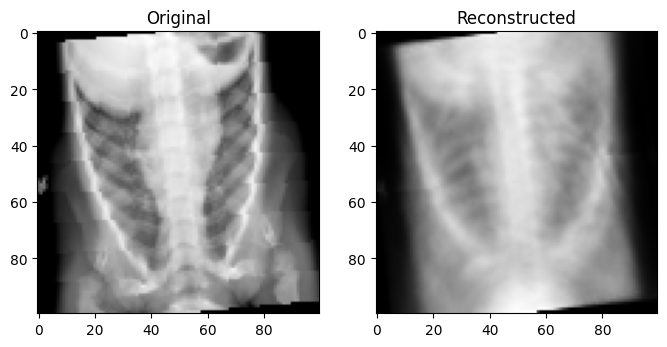

In [ ]:
# Plot some original and reconstructed images
n_samples = 3  # Number of samples to visualize
with torch.no_grad():
    for i, batch in enumerate(train_dl):
        if i >= n_samples:
            break
        batch = batch.to(device)
        batch = batch.flatten(1)
        reconstructed = dec(enc(batch))

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title('Original')
        plt.imshow(batch[0].view(100, -1).cpu().numpy(), cmap='gray')  # Reshape to original size

        plt.subplot(1, 2, 2)
        plt.title('Reconstructed')
        # plt.imshow(reconstructed.view(100, -1).cpu().numpy(), cmap='gray')  # Reshape to original size
        plt.imshow(reconstructed[0].view(100,100).cpu().numpy(), cmap='gray')  # Reshape to original size


        plt.show()
